# DotA -analysis

Data source: OpenDota API, https://docs.opendota.com/ <br> 
Data range 4.10.2012 - 28.04.2020 <br>
Data from: Jonu, Ika_bono, Kaamio, Naakka, fDiamond <br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator

pd.set_option('display.max_rows', 500)
plt.style.use('ggplot')

In [2]:
#Read in the data. df_heros contains the hero roles. 
df = pd.read_csv("./matches_with_teams.csv", index_col = 'index')
df_heros = pd.read_csv("./heroes_with_roles.csv", index_col = 'index')

# Data wrangling and exploration

In [3]:
#Data date range:
print(df['start_time'].min())
print(df['start_time'].max())

2012-10-04
2020-04-28


In [4]:
#Replace numerical values with  more descriptive ones.

players = {490408 : 'Jonu', 54936413:'Kaamio', 232851:'fDiamond', 113894237:'ika_bono',118764669:'Naakka'}
game_modes = {0:'Unknown', 1:'all_pick', 2:'captains_mode', 3:'random_draft', 4:'single_draft', 5:'all_random', 12:'least_played', 16:'captains_draft', 22:'all_pick'}
lobby_types = {0: 'normal', 7:'ranked', 9: 'battle_cup'}
skill_levels = {np.nan:'unknown', 1:'normal', 2:'high', 3:'very_high'}

In [5]:
df = df.replace({'game_mode':game_modes, 'lobby_type': lobby_types, 'skill':skill_levels, 'steam_id':players})

In [6]:
#Remove some unneeded columns and replace nan-values with 0 in the party_size-column.
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1, inplace=True)

In [7]:
df_heros.drop(['Unnamed: 0','name'], axis=1, inplace=True)

In [8]:
df['party_size'].fillna(0, inplace=True);

In [9]:
#Remove games that lasted less than 10 minutes.
df = df[df['duration']>600]

In [10]:
#This function assigns patch version based on the date of the game. Patch dates were taken from the dota wiki.
def assign_version(date, version):
    if date < '2012-10-21':
        return 6.75
    elif date < '2012-12-15':        
        return 6.76
    elif date < '2013-05-03':
        return 6.77
    elif date < '2013-10-21':
        return 6.78
    elif date < '2014-01-27':
        return 6.80
    elif date < '2014-04-29':
        return 6.81
    elif date < '2014-09-24':
        return 6.82
    elif date < '2014-12-17':
        return 6.83
    elif date < '2015-04-30':
        return 6.84
    elif date < '2015-09-24':
        return 6.85
    elif date < '2015-12-16':
        return 6.86
    elif date < '2016-04-25':
        return 6.87
    elif date < '2016-06-12':
        return 6.88
    elif date < '2016-12-12':
        return 7.00
    elif date < '2017-05-15':
        return 7.06
    elif date < '2017-10-31':
        return 7.07
    elif date < '2018-03-01':
        return 7.10
    elif date < '2018-03-29':
        return 7.12
    elif date < '2018-04-26':
        return 7.14
    elif date < '2018-05-27':
        return 7.16
    elif date < '2018-07-29':
        return 7.19
    elif date < '2018-11-19':
        return 7.20
    elif date < '2019-01-29':
        return 7.21
    elif date < '2019-05-24':
        return 7.22
    elif date < '2019-11-26':
        return 7.23
    elif date < '2020-01-26':
        return 7.24
    elif date < '2020-03-17':
        return 7.25
    else:
        return 7.26


In [11]:
df['version'] = df.apply(lambda x: assign_version(x.start_time, x.version), axis=1)

In [12]:
#Combine hero data with match data 
df = df.merge(df_heros, left_on='hero_id', right_on='localized_name', how='left')

In [13]:
#Hero roles are binary coded, switch type from float --> int
df.loc[:,'Carry':'Escape'] = df.loc[:,'Carry':'Escape'].astype(int)

In [14]:
#Convert date to datetime for easier plotting.
df['start_time']= pd.to_datetime(df['start_time'])

In [15]:
# Calculate running win% for the entire dataframe

#Sort value first to get functioning time series
df.sort_values(by='start_time',axis=0,inplace=True)
win_percent = pd.DataFrame(np.zeros(df.shape[0]))
pd.concat([df,win_percent],axis=1)

row_count = 1
wins = 0

#Iterate each row and calculate wins / count of rows iterated(=games)
for idx, row in df.iterrows():
    if df.at[idx,'win'] == 1:
        wins += 1   
    df.at[idx,'win_percent'] = wins/row_count
    row_count += 1

In [16]:
df.head()

,match_id,player_slot,radiant_win,duration,game_mode,lobby_type,hero_id,start_time,version,kills,...,Support,Disabler,Lane support,Initiator,Jungler,Durable,Nuker,Pusher,Escape,win_percent
2413,46215744,131,1,1550,Unknown,normal,Axe,2012-10-04,6.75,0,...,0,1,0,1,1,1,0,0,0,0.00
2412,48616751,2,0,3051,Unknown,normal,Chaos Knight,2012-10-11,6.75,4,...,0,1,0,1,0,1,0,1,0,0.00
2411,48644986,129,1,2111,Unknown,normal,Chaos Knight,2012-10-11,6.75,4,...,0,1,0,1,0,1,0,1,0,0.00
1205,49943204,3,1,1680,Unknown,normal,Lifestealer,2012-10-15,6.75,3,...,0,1,0,0,1,1,0,0,1,0.25
1207,49866651,131,0,1836,Unknown,normal,Chaos Knight,2012-10-15,6.75,10,...,0,1,0,1,0,1,0,1,0,0.40


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14123 entries, 2413 to 7630
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   match_id        14123 non-null  int64         
 1   player_slot     14123 non-null  int64         
 2   radiant_win     14123 non-null  int64         
 3   duration        14123 non-null  int64         
 4   game_mode       14123 non-null  object        
 5   lobby_type      14123 non-null  object        
 6   hero_id         14123 non-null  object        
 7   start_time      14123 non-null  datetime64[ns]
 8   version         14123 non-null  float64       
 9   kills           14123 non-null  int64         
 10  deaths          14123 non-null  int64         
 11  assists         14123 non-null  int64         
 12  skill           14123 non-null  object        
 13  leaver_status   14123 non-null  int64         
 14  party_size      14123 non-null  float64       
 15  

# Game analysis

In [18]:
#Games per patch 
#Patch 6.82: bounty runes and Crimson guard added. Killstreak gold reworked. 

print(df['version'].value_counts().sort_values(ascending=False))

6.82    1294
7.00    1291
7.07    1194
6.87    1137
6.85     807
6.80     796
7.06     742
6.84     738
7.10     674
7.20     660
6.78     552
7.23     543
6.86     537
7.22     502
6.83     385
6.81     299
7.19     269
6.88     263
7.16     234
7.21     218
7.14     203
7.24     199
7.12     186
6.77     167
7.25      95
7.26      91
6.76      35
6.75      12
Name: version, dtype: int64


In [19]:
# Most kills / assists / deaths in a single game

most_kills = df[df['kills'] == df['kills'].max()]
print(most_kills[['kills','duration', 'game_mode',  'hero_id', 'start_time', 'steam_id']])
print()
most_assists = df[df['assists'] == df['assists'].max()]
print(most_assists[['assists', 'duration', 'game_mode',  'hero_id', 'start_time', 'steam_id']])
print()
most_deaths =df[df['deaths'] == df['deaths'].max()]
print(most_deaths[['deaths', 'duration', 'game_mode',  'hero_id', 'start_time', 'steam_id']])

      kills  duration game_mode           hero_id start_time  steam_id
5314     53      4365  all_pick  Phantom Assassin 2018-09-24  fDiamond

      assists  duration     game_mode    hero_id start_time  steam_id
9141       47      4757  random_draft  Clockwerk 2017-04-16  fDiamond

       deaths  duration     game_mode        hero_id start_time steam_id
13437      24      3665  random_draft  Shadow Shaman 2017-02-05   Naakka


In [20]:
#Top 5 days by game count
df['start_time'].value_counts().head()

2017-09-16    80
2020-01-25    71
2019-03-23    64
2018-09-29    64
2018-04-28    59
Name: start_time, dtype: int64

In [21]:
#Games won on said days....
for i in df['start_time'].value_counts().head().index:
    temp= df[df['start_time']==i]    
    print(temp['win'].sum())

45
24
28
30
20


In [22]:
#Group games by day for bar graph visualization. Will be grouped by month later
df_id = df.copy()
df_id = df_id.groupby('start_time')['match_id'].count()

#Groupby returns a series, convert this to dataframe for easier visualization
df_id = pd.DataFrame(df_id)

In [23]:
df_win = df[['start_time', 'win_percent']]
df_win = df_win.set_index('start_time')
df_win = df_win.resample('M').mean()

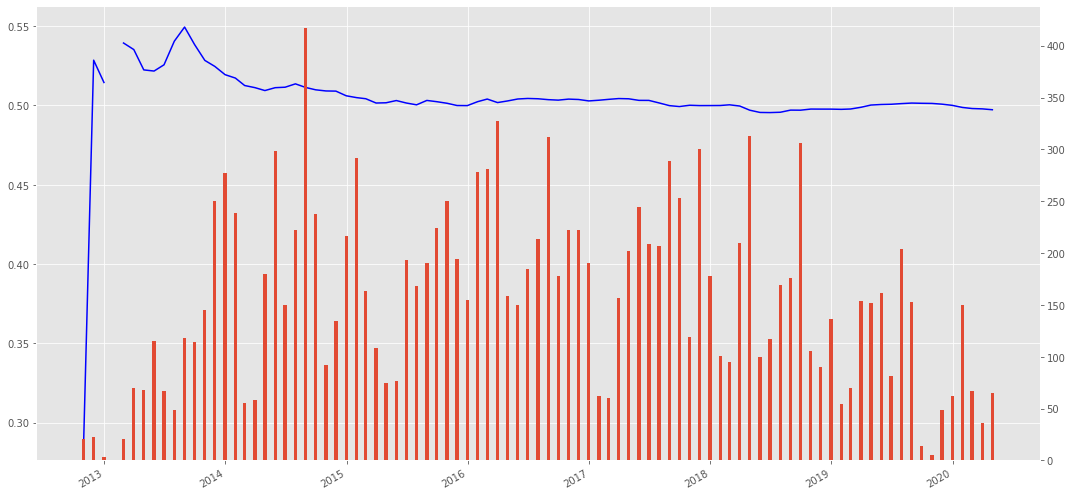

In [24]:
#Aggregate data by month. df_id has the match coutnts, df
df_id_games = df_id.groupby(pd.Grouper(freq='M')).sum()
df_win_games = df_win.groupby(pd.Grouper(freq='M')).mean()
fig, ax = plt.subplots(figsize=(15,7))
ax2 = ax.twinx()

ax.plot(df_win_games['win_percent'], color='blue')
ax2.bar(df_id_games.index, df_id_games['match_id'], width=10, label='Games')

ax2.grid(b=False)
fig.autofmt_xdate()
ax.axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.tight_layout()
plt.show();

In [25]:
# Wins / games in different skill brackets. 

df_skill = df.loc[:,'skill']
df_skill = pd.concat([df_skill, df['win']],axis=1)
df_skill_counts = df_skill.groupby('skill').count()
df_skill = df_skill.groupby('skill')['win'].sum()

for ind,i in enumerate(df_skill):
    print(f'{df_skill.index[ind]} : {df_skill[ind]} / {df_skill_counts.iloc[ind,0]}')


high : 254 / 595
normal : 1244 / 2602
unknown : 5434 / 10713
very_high : 89 / 213


# Hero performance statistics

In [26]:
hero_df = pd.crosstab(index=df['hero_id'], columns=df['win'])

In [27]:
hero_df.rename(columns={0:'loss',1:'win'},inplace= True)

In [28]:
hero_df['win%'] = hero_df['win']/(hero_df['win']+hero_df['loss'])

In [29]:
hero_df.sort_values(by='win%',inplace=True,ascending=False)

In [30]:
hero_df_most_played = hero_df[(hero_df['loss']+hero_df['win']>30)]

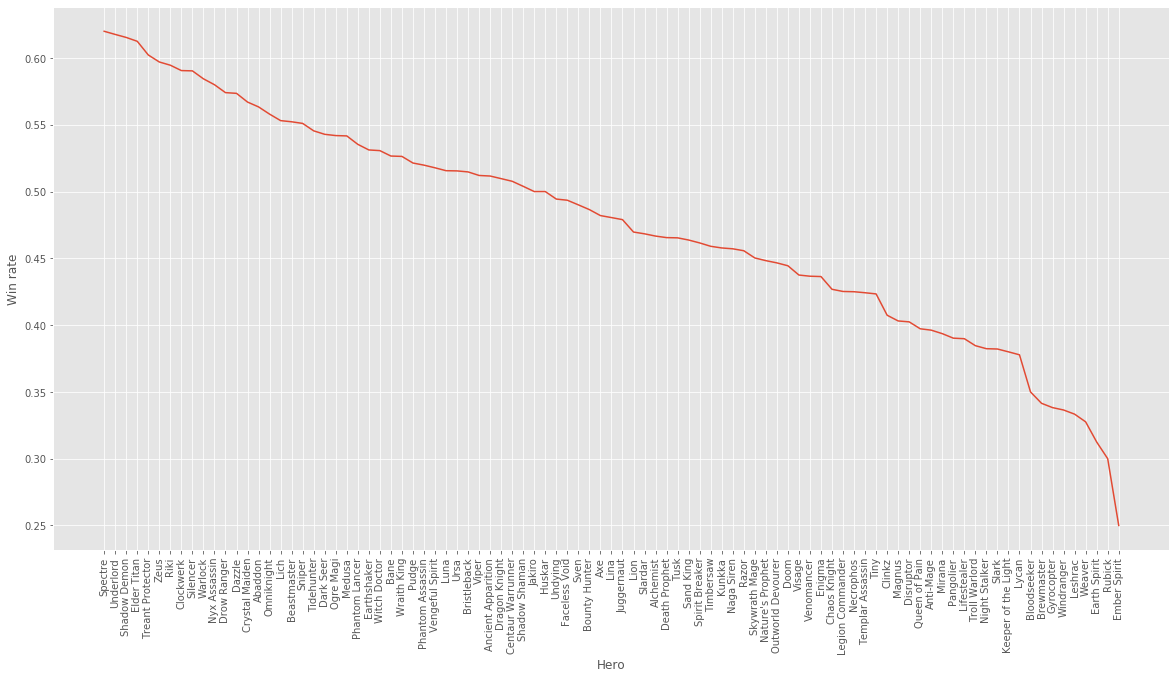

In [31]:
#Hero win rates. Only heros with more than 30 games are included.
fig = plt.figure(figsize=(20,10))
plt.plot(hero_df_most_played.index, hero_df_most_played['win%'])
plt.xlabel('Hero')
plt.ylabel('Win rate')
plt.xticks(rotation=90);

In [32]:
print(hero_df_most_played)

win                  loss  win      win%
hero_id                                 
Spectre                38   62  0.620000
Underlord              13   21  0.617647
Shadow Demon           15   24  0.615385
Elder Titan            31   49  0.612500
Treant Protector       35   53  0.602273
Zeus                   27   40  0.597015
Riki                   75  110  0.594595
Clockwerk             287  414  0.590585
Silencer               34   49  0.590361
Warlock               128  180  0.584416
Nyx Assassin           21   29  0.580000
Drow Ranger            69   93  0.574074
Dazzle                 87  117  0.573529
Crystal Maiden        210  275  0.567010
Abaddon                31   40  0.563380
Omniknight             61   77  0.557971
Lich                  122  151  0.553114
Beastmaster            30   37  0.552239
Sniper                 66   81  0.551020
Tidehunter             85  102  0.545455
Dark Seer              32   38  0.542857
Ogre Magi             153  181  0.541916
Medusa          

In [33]:
#Which heros have been played less than 30 times? Dem Tinker stats...
hero_df[(hero_df['loss']+hero_df['win']<30)]

win,loss,win,win%
hero_id,,,
Monkey King,2,6,0.750000
Mars,2,3,0.600000
Shadow Fiend,13,11,0.458333
Morphling,6,5,0.454545
Enchantress,12,9,0.428571
Batrider,10,7,0.411765
Grimstroke,9,6,0.400000
Puck,14,9,0.391304
Pugna,18,11,0.379310


In [34]:
# Which roles have been the most succesful? Durable support initiators...the dream combo

df_z = df.loc[:,'Carry':'Escape']
df_z = pd.concat([df_z, df['win']],axis=1)
df_z = df_z.groupby('win').sum()
df_z.drop('Lane support',inplace=True,axis=1)

In [35]:
df_z.T.head(10)

win,0,1
Carry,3052,2715
Support,3329,3441
Disabler,5745,5682
Initiator,3965,4015
Jungler,835,800
Durable,2787,2877
Nuker,5484,5347
Pusher,1162,996
Escape,2092,1829


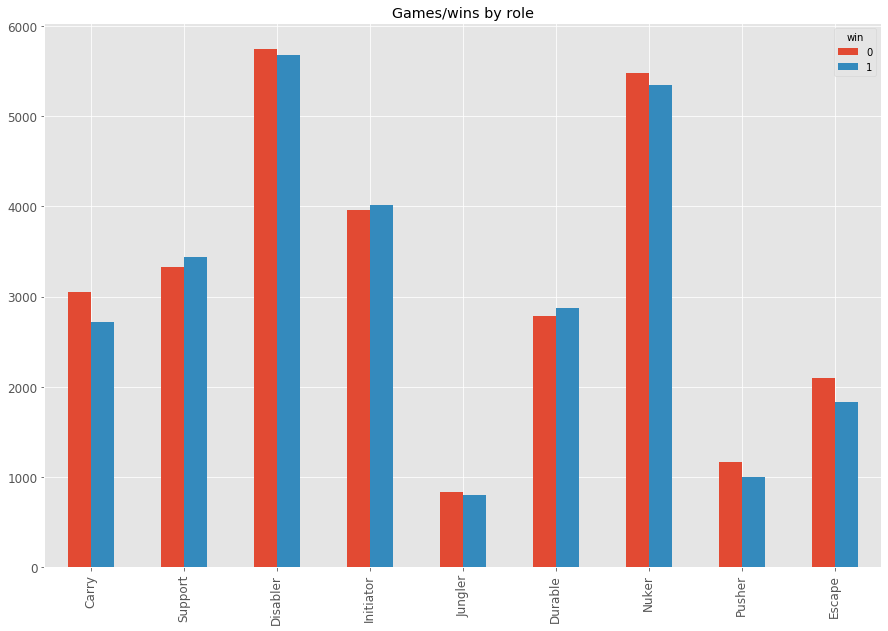

In [36]:
ax = df_z.T[[0,1]].plot(kind='bar', title ="Games/wins by role",figsize=(15,10),legend=True, fontsize=12)

In [37]:
#Which heros have the sacred triforce...
df_roles = df[(df['Support'] == 1) & (df['Durable']==1) & (df['Initiator']==1)]
df_roles['hero_id'].value_counts()

#The magus reigns supreme

Ogre Magi           334
Kunkka              225
Wraith King         171
Treant Protector     88
Alchemist            45
Name: hero_id, dtype: int64

In [38]:
#How about for each player? It seems that no one is doing particularly well with carries.
df_z = df.loc[:,'Carry':'Escape']
df_z = pd.concat([df_z, df['win'], df['steam_id']],axis=1)
df_z.groupby(['steam_id','win']).sum()

Carry  Support  Disabler  Lane support  Initiator  Jungler  \
steam_id win                                                               
Jonu     0      498      692      1008             0        521      158   
         1      420      772      1045             0        519      190   
Kaamio   0      423      568       982             0        603      114   
         1      387      593       987             0        602       87   
Naakka   0      432      460       676             0        486       97   
         1      394      426       595             0        455       76   
fDiamond 0     1170     1276      2420             0       1900      376   
         1     1054     1251      2409             0       1969      369   
ika_bono 0      529      333       659             0        455       90   
         1      460      399       646             0        470       78   

              Durable  Nuker  Pusher  Escape  
steam_id win                                  
Jonu     0        353    948     199     348  
         1        339    959     174     306  
Kaamio   0        455    930     164     284  
         1        476    943     158     264  
Naakka   0        376    767     162     260  
         1        374    700     140     197  
fDiamond 0       1246   2200     402     906  
         1       1332   2149     336     811  
ika_bono 0        357    639     235     294  
         1        356    596     188     251

## Game duration analysis

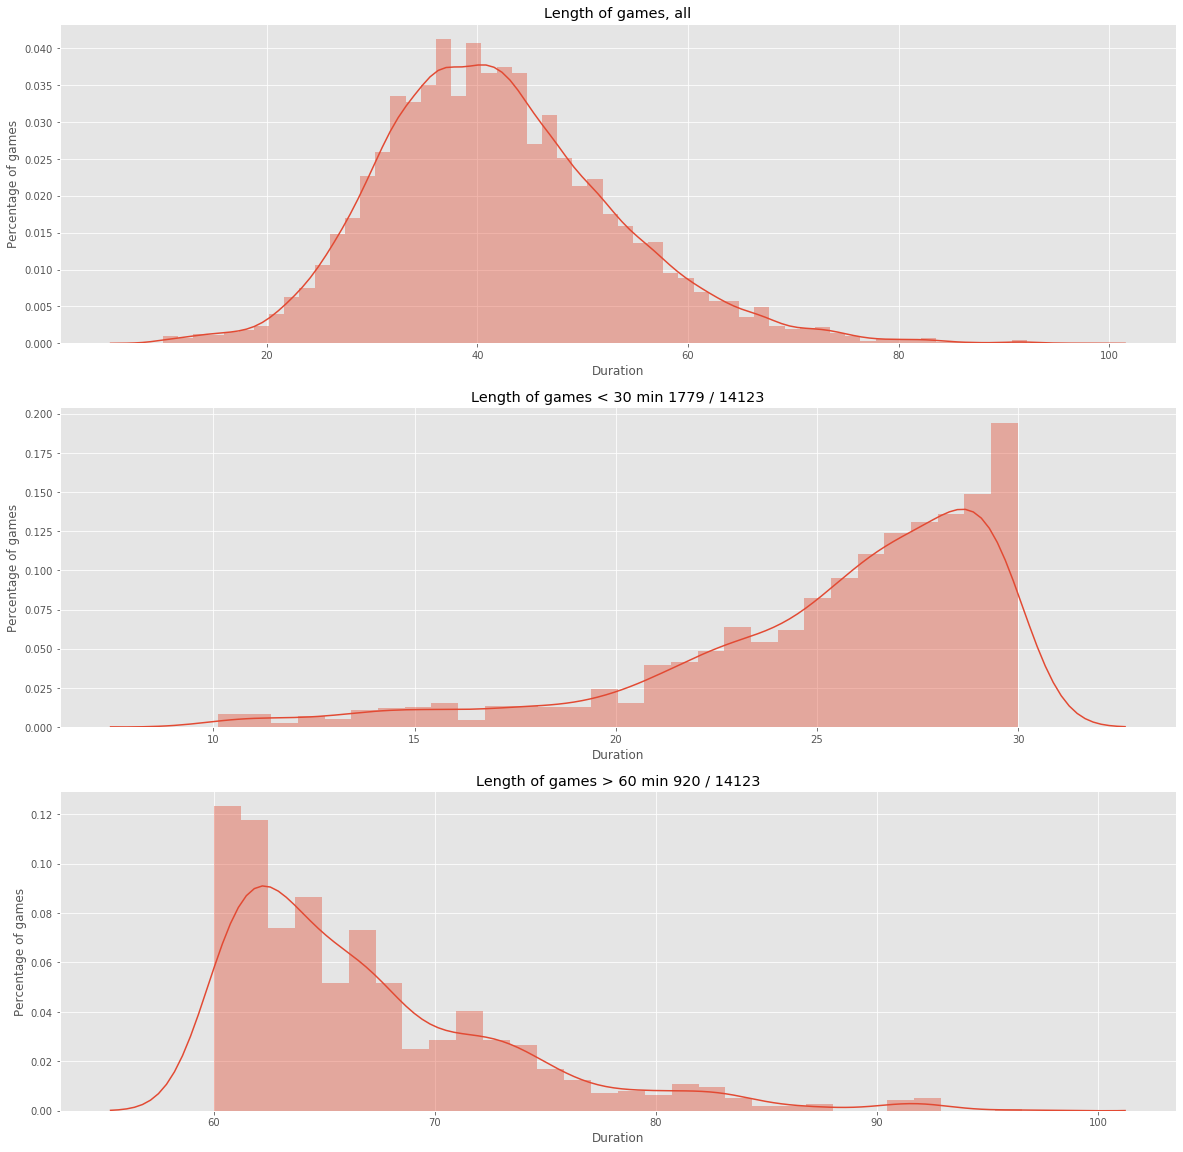

In [70]:
#Average game seems to last for about 35-45 minutes. Shorter games are more common than long ones.

fig = plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
time = (df['duration']/60)
sns.distplot(time, bins=60)

plt.title('Length of games, all')
plt.xlabel('Duration')
plt.ylabel('Percentage of games');

plt.subplot(3,1,2)
short_games = df[df['duration']<1800]
sns.distplot(short_games['duration']/60, bins=30)
plt.title(f'Length of games < 30 min {short_games.shape[0]} / {df.shape[0]}')
plt.xlabel('Duration')
plt.ylabel('Percentage of games');


plt.subplot(3,1,3)
long_games = df[df['duration']>3600]
sns.distplot(long_games['duration']/60, bins=30)
plt.title(f'Length of games > 60 min {long_games.shape[0]} / {df.shape[0]}')
plt.xlabel('Duration')
plt.ylabel('Percentage of games');

In [40]:
#Divide dataframe into sections based on game length

df10_20 = df[df['duration']<1200]
df20_30 = df[(df['duration']>1200) & (df['duration']<1800)]
df30_40 = df[(df['duration']>1800) & (df['duration']<2400)]
df40_50 = df[(df['duration']>2400) & (df['duration']<2800)]
df50_60 = df[(df['duration']>2800) & (df['duration']<3200)]
df60 = df[df['duration']>3200]

times = [df10_20, df20_30, df30_40, df40_50, df50_60, df60]

In [41]:
#Games lasting between 20 and 30 mins seem to have the worst winrate. 

for t in times:
    wins = t['win'].sum()
    average_length = t['duration'].mean()
    print(f'avg. length {int(average_length/60)} mins:  wins / losses / win%: {wins} / {t.shape[0]} / {wins/t.shape[0]*100} ')

avg. length 15 mins:  wins / losses / win%: 96 / 189 / 50.79365079365079 
avg. length 26 mins:  wins / losses / win%: 728 / 1587 / 45.87271581600504 
avg. length 35 mins:  wins / losses / win%: 2366 / 4816 / 49.127906976744185 
avg. length 43 mins:  wins / losses / win%: 1669 / 3251 / 51.338049830821284 
avg. length 49 mins:  wins / losses / win%: 1073 / 2148 / 49.95344506517691 
avg. length 60 mins:  wins / losses / win%: 1073 / 2101 / 51.07091861018562 


## Enemy lineups

In [42]:
#Create array for binary hero values.
hero_columns = np.arange(1,130)
hero_array = np.zeros((df.shape[0], len(hero_columns)))    

In [43]:
#create dataframe df_enemy that has all hero id's as columns in addition to other columns.
df_enemy = pd.concat([df, pd.DataFrame(hero_array,columns=hero_columns)], axis=1) 

In [44]:
df_enemy.reset_index(drop=True, inplace=True)

In [45]:
# Iterate each row of the dataframe: enemy_team contains a list as string containing enemy lineup. Convert each hero id to int
# and set the corresponding id col to 1.

heros = df_enemy
for ind, row in heros.iterrows():
    enemy = row['enemy_team']
    enemy = enemy.replace('[', '')
    enemy = enemy.replace(']','')
    enemy = enemy.split(',')

    for idx,hero in enumerate (enemy):        
        hero = hero.strip()
        hero = int(float(hero))
        if hero in heros.columns:                
            heros.at[ind, hero] = 1

In [46]:
# Set column types to int 
heros[hero_columns] = heros[hero_columns].astype(int)

In [47]:
# The hero id's are not linear, some hero id's dont exist. Drop those next:
heros = heros.loc[:, (heros != 0).any(axis=0)]

In [48]:
#hero_data.csv contains heroes, their id's and corresponding names.
hero_id = pd.read_csv('./hero_data.csv',index_col='0',usecols=['1','0'])

In [50]:
# herot contains all heroes as list ordered by hero id
herot = list(hero_id['1'])

In [51]:
# temp_cols: all other columns except hero names from the original df.
temp_cols = list(heros.columns[:34])

In [52]:
# Column names for the final df: new_col_names
new_col_names = temp_cols + herot

In [54]:
heros.columns = new_col_names

In [55]:
hero_counts = heros.iloc[:,35:-1].sum().sort_values(ascending=False)

In [56]:
hero_counts = pd.DataFrame(hero_counts)

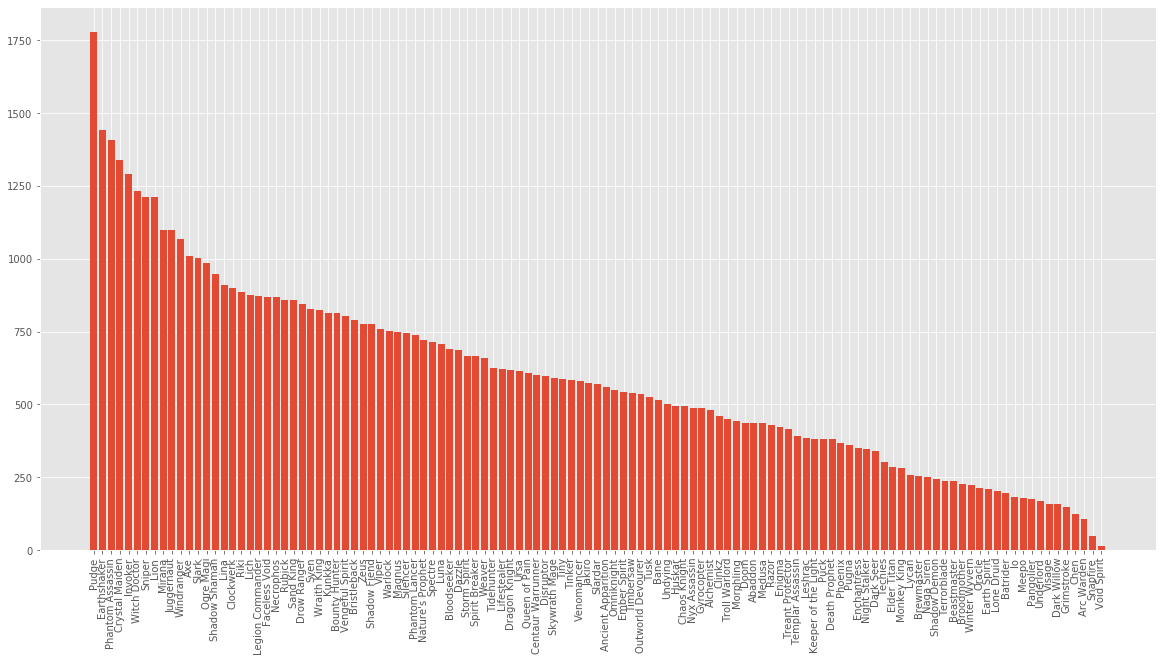

In [57]:
# How many times each hero has been on the enemy team:
fig,ax = plt.subplots(figsize=(20,10))
ax.bar(hero_counts.index, hero_counts[0])
plt.xticks(rotation=90);

In [58]:
hero_counts.rename(columns={0:'count'}, inplace=True)

In [59]:
hero_counts

,count
Pudge,1776
Earthshaker,1440
Phantom Assassin,1406
Crystal Maiden,1338
Invoker,1292
Witch Doctor,1231
Sniper,1210
Lion,1210
Mirana,1100
Juggernaut,1100


In [60]:
enemy_win_rates = heros.loc[:,'win':'Void Spirit'].groupby('win').sum()

In [61]:
win_rates_by_hero = enemy_win_rates.drop(enemy_win_rates.loc[:,'legs':'win_percent'],axis=1).T

In [62]:
win_rates_by_hero.drop('id',axis=0,inplace=True)

In [63]:
#Calculate win rates against each hero in enemy lineups.
win_rates_by_hero['win%'] = win_rates_by_hero[1]/(win_rates_by_hero[0]+win_rates_by_hero[1])

In [64]:
#Top 20 heroes with worst win% against
win_rates_by_hero.sort_values(by='win%').head(20)

win,0,1,win%
Void Spirit,11,5,0.312500
Visage,97,63,0.393750
Chen,74,50,0.403226
Brewmaster,147,106,0.418972
Pangolier,98,79,0.446328
Vengeful Spirit,444,359,0.447073
Queen of Pain,334,274,0.450658
Leshrac,210,174,0.453125
Lion,659,551,0.455372
Enchantress,191,160,0.455840


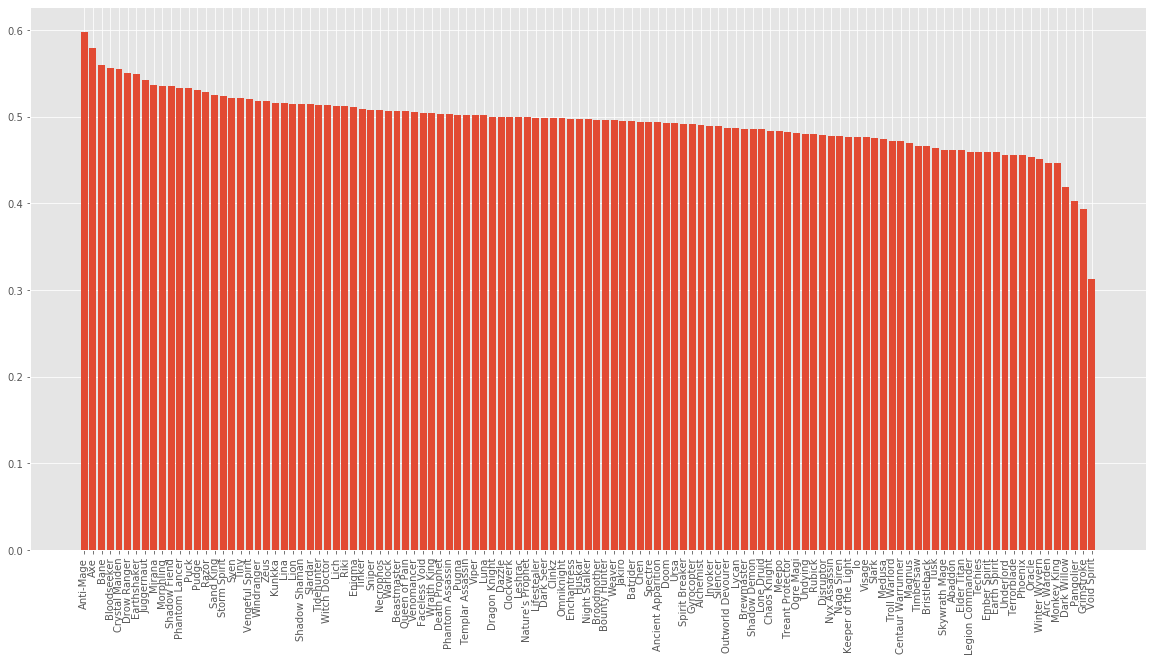

In [69]:
fig,ax = plt.subplots(figsize=(20,10))
ax.bar(win_rates_by_hero.index, win_rates_by_hero['win%'].sort_values(ascending=False))
plt.xticks(rotation=90);